# Affirm Data Challenge
#### Xi Chelsea Qiu
#### 2019-08-03


In [1]:
import os
import re

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sklearn
import matplotlib.pyplot as plt

os.getcwd()

'/Users/chelsea/Python/affirm'

### Please answer the following questions:
1. What would you say drives the variance between actual and predicted repayment?
2. What could drive the difference between auth_amount and loan_amount?
3. Based on the data, in which areas would you increase or decrease volume?
4. Which categories generate the most profit for Company XYZ?
5. What information can Company XYZ gather to further evaluate their merchants’ profit?
6. What types of analysis, evaluation, or diligence should Company XYZ do?

### Import data

In [ ]:
path='/Users/chelsea/Python/affirm/'
mrch_cat=pd.read_csv(path+'merchant_category_mapping.csv')
mrch_name=pd.read_csv(path+'merchant_name_mapping.csv')
perf=pd.read_csv(path+'performance_dataset.csv')

### Data Dictionary:
1. category / Subcategory: Merchant’s industry
2. name: name of the merchant
3. merchant_id: Unique identifier for the merchant
4. actual_repayment_pct: actual percentage of loan volume that is repaid
5. predicted_repayment_pct: predicted percentage of loan volume that is repaid
6. num_trxn: number of loans per merchant
7. auth_amt: total amount of user requests / apply for
8. loan_amt: total amount of the loan
9. fico: score that measures a user’s risk, higher score means less risk (range from 300-850)
10. term: Duration of the loan
11. apr: annual percentage rate (interest rate that charged to the user)

### 1. Explore the Datasets

In [8]:
print('mrch_cat: Distinct merchant id: ', mrch_cat.merchant_id.nunique())
print('mrch_name: Distinct merchant id: ', mrch_name.merchant_id.nunique())
print('Perf: Distinct merchant id: ', perf.merchant_id.nunique())

mrch_cat: Distinct merchant id:  143
mrch_name: Distinct merchant id:  143
Perf: Distinct merchant id:  143


In [10]:
### Checking Missing percentatge
mrch_cat.isnull().sum()/mrch_cat.count()

category       0.014184
subcategory    0.051471
merchant_id    0.000000
dtype: float64

In [11]:
### Checking Missing percentatge
mrch_name.isnull().sum()/mrch_name.count()

name           0.0
merchant_id    0.0
dtype: float64

In [235]:
mrch=mrch_name.merge(mrch_cat, on=['merchant_id'], how='left')
### Combine WOMENs Fashion and Men's Fashion
mrch.loc[(mrch['category']=='WOMENS_FASHION')|(mrch['category']=='MENS_FASHION')|(mrch['category']=='BEAUTY'), 'category']='FASHION_BEAUTY'
mrch.head()

,name,merchant_id,category,subcategory
0,UCXMYZC,42733,OTHER,Wireless Telecommunications Carriers (except S...
1,OQFYEDO,28833,JEWELRY,Jewelry Stores - 448310
2,LVMCHQE,83007,JEWELRY,Jewelry Stores - 448310
3,QIGSCCQ,66431,OTHER,All Other Health and Personal Care Stores - 44...
4,DCZPIEU,61453,OTHER,Sporting Goods Stores - 451110


In [236]:
mrch.isnull().sum()

name           0
merchant_id    0
category       2
subcategory    7
dtype: int64

In [216]:
mrch.subcategory.nunique()

27

In [19]:
## take a look at the missing category
mrch.loc[mrch['category'].isnull()>0]

,name,merchant_id,category,subcategory
27,LYMLCLF,86469,NaN,Women's Clothing Stores - 448120
48,BUOLYBH,47147,NaN,Electronics Stores - 443142


In [18]:
## take a look at the missing sub-category
mrch.loc[mrch['subcategory'].isnull()>0]

,name,merchant_id,category,subcategory
22,QAYXIAW,91371,HOME_FURNISHINGS,NaN
30,VRCTBDG,57643,OTHER,NaN
44,LOMGEQM,58529,OTHER,NaN
71,PIYXFMT,45593,OTHER,NaN
75,GFVUDGC,75304,OTHER,NaN
123,OXLOFHO,78100,CONSUMER_ELECTRONICS,NaN
141,WHOJNDV,73545,OTHER,NaN


#### Checking the current Category vs. Sub-Category Mapping

In [237]:
orig_mapping=pd.DataFrame(mrch.groupby(['subcategory','category']).merchant_id.nunique())
orig_mapping
### IF a subcategory is mapped to multiple category,take the category with more merchant, or whichever makes more sense

merchant_id
subcategory                                        category                         
All Other Health and Personal Care Stores - 446199 CONSUMER_ELECTRONICS            1
                                                   OTHER                          14
All Other Miscellaneous Schools and Instruction... OTHER                           1
                                                   PERSONAL_SERVICE                1
Automotive Parts and Accessories Stores - 441310   AUTO_PARTS                      5
                                                   OTHER                           1
Business to Business Electronic Markets - 425110   CONSUMER_ELECTRONICS            3
                                                   OTHER                           1
Clothing Accessories Stores - 448150               FASHION_BEAUTY                  3
                                                   OTHER                           3
Cosmetics, Beauty Supplies, and Perfume Stores ... FASHION_BEAUTY                  1
Electrical Contractors and Other Wiring Install... HOME_FURNISHINGS                1
Electronics Stores - 443142                        CONSUMER_ELECTRONICS            2
                                                   OTHER                           5
Elementary and Secondary Schools - 611110          CONSUMER_ELECTRONICS            1
Furniture Stores - 442110                          HOME_FURNISHINGS               17
                                                   OTHER                           2
Gift, Novelty, and Souvenir Stores - 453220        OTHER                           1
Hardware Stores - 444130                           HOME_FURNISHINGS                1
Hobby, Toy, and Game Stores - 451120               OTHER                           3
Jewelry Stores - 448310                            JEWELRY                        21
                                                   OTHER                           6
Luggage and Leather Goods Stores - 448320          FASHION_BEAUTY                  2
Motorcycle, ATV, and All Other Motor Vehicle De... OTHER                           1
Musical Instrument and Supplies Stores - 451140    CONSUMER_ELECTRONICS            2
                                                   OTHER                          10
Offices of Dentists - 621210                       PERSONAL_SERVICE                1
Other Building Material Dealers - 444190           HOME_FURNISHINGS                1
Pet and Pet Supplies Stores - 453910               OTHER                           1
Professional and Management Development Trainin... OTHER                           1
Security Systems Services (except Locksmiths) -... OTHER                           2
Service Establishment Equipment and Supplies Me... OTHER                           2
Shoe Stores - 448210                               OTHER                           1
Sporting Goods Stores - 451110                     OTHER                          10
Wireless Telecommunications Carriers (except Sa... CONSUMER_ELECTRONICS            1
                                                   OTHER                           1
Women's Clothing Stores - 448120                   FASHION_BEAUTY                  4

In [259]:
### rename 'OTHER' to primary categories
mapping=pd.DataFrame(mrch.loc[mrch['category']!='OTHER'].groupby(['subcategory','category']).merchant_id.nunique())
mapping.reset_index(inplace=True)
### Mannual Adjust
mapping.loc[mapping['subcategory']=='All Other Health and Personal Care Stores - 446199','category']='PERSONAL_SERVICE'
mapping.loc[mapping['subcategory']=='Elementary and Secondary Schools - 611110','category']='OTHER'

mapping=mapping[['subcategory','category']]
mapping

,subcategory,category
0,All Other Health and Personal Care Stores - 44...,PERSONAL_SERVICE
1,All Other Miscellaneous Schools and Instructio...,PERSONAL_SERVICE
2,Automotive Parts and Accessories Stores - 441310,AUTO_PARTS
3,Business to Business Electronic Markets - 425110,CONSUMER_ELECTRONICS
4,Clothing Accessories Stores - 448150,FASHION_BEAUTY
5,"Cosmetics, Beauty Supplies, and Perfume Stores...",FASHION_BEAUTY
6,Electrical Contractors and Other Wiring Instal...,HOME_FURNISHINGS
7,Electronics Stores - 443142,CONSUMER_ELECTRONICS
8,Elementary and Secondary Schools - 611110,OTHER
9,Furniture Stores - 442110,HOME_FURNISHINGS


In [260]:
### reassign 'OTHER' to primary categories 
other=mrch.loc[(mrch['category']=='OTHER')|(mrch['category'].isnull())][['merchant_id','subcategory']]
other=other.merge(mapping, on=['subcategory'], how='left')
other.rename(columns={'category':'category_m'},inplace=True)
other.loc[other['category_m'].isnull(), 'category_m']='OTHER'
other.isnull().sum()/other.count()

merchant_id    0.000000
subcategory    0.073529
category_m     0.586957
dtype: float64

In [262]:
other=other[['merchant_id','category_m']]
mrch2=mrch.merge(other, on='merchant_id', how='left')
mrch2.loc[mrch2['category_m'].isnull(), 'category_m']=mrch2.loc[mrch2['category_m'].isnull(), 'category']
mrch2.isnull().sum()

name           0
merchant_id    0
category       2
subcategory    7
category_m     0
dtype: int64

In [337]:
## take a look at the missing original category
mrch2.loc[mrch['category'].isnull()>0]

,name,merchant_id,category,subcategory,category_m
27,LYMLCLF,86469,NaN,Women's Clothing Stores - 448120,FASHION_BEAUTY
48,BUOLYBH,47147,NaN,Electronics Stores - 443142,CONSUMER_ELECTRONICS


#### Check the final distribution of cleaned merchant category

In [263]:
mrch2.groupby(['category_m','subcategory']).merchant_id.count()

category_m            subcategory                                                               
AUTO_PARTS            Automotive Parts and Accessories Stores - 441310                               6
CONSUMER_ELECTRONICS  All Other Health and Personal Care Stores - 446199                             1
                      Business to Business Electronic Markets - 425110                               4
                      Electronics Stores - 443142                                                    8
                      Elementary and Secondary Schools - 611110                                      1
                      Musical Instrument and Supplies Stores - 451140                               12
                      Wireless Telecommunications Carriers (except Satellite) - 517210               2
FASHION_BEAUTY        Clothing Accessories Stores - 448150                                           6
                      Cosmetics, Beauty Supplies, and Perfume Stores - 446120  

Text(0.5,1,'Merchant Distribution by Modified Category')

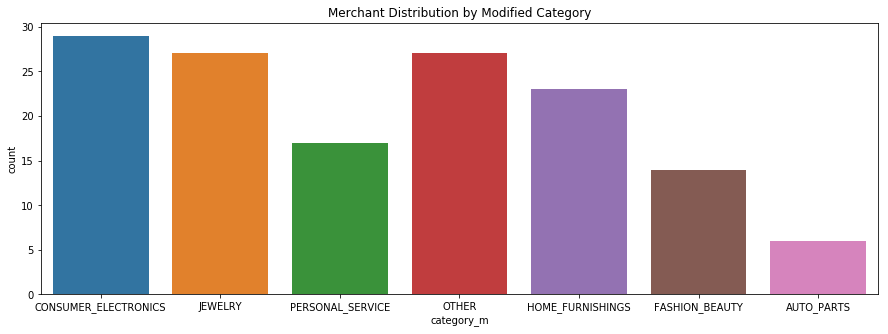

In [339]:
plt.figure(figsize=(15,5))
sns.countplot("category_m",data=mrch2)
plt.title('Merchant Distribution by Modified Category')

#### Performance Dataset 

In [12]:
perf.head()

,merchant_id,actual_repayment_pct,predicted_repayment_pct,num_trxn,avg_auth_amt,avg_loan_amt,avg_fico,avg_term,avg_apr
0,78986,0.927466,0.948425,6331,491.650278,473.727737,643,8,0.251198
1,54871,0.983798,0.978641,3293,862.996710,862.555109,715,6,0.000000
2,86469,0.936782,0.965042,2670,636.689936,620.229734,664,8,0.214657
3,42719,0.961743,0.945634,570,719.714054,692.877934,655,10,0.257577
4,40242,0.867273,0.902408,317,380.978427,374.832065,626,9,0.160714


In [9]:
### Checking Missing percentatge
perf.isnull().sum()/perf.count()

merchant_id                0.0
actual_repayment_pct       0.0
predicted_repayment_pct    0.0
num_trxn                   0.0
avg_auth_amt               0.0
avg_loan_amt               0.0
avg_fico                   0.0
avg_term                   0.0
avg_apr                    0.0
dtype: float64

### Merge the merchant mapping table to the performance table

In [267]:
data=perf.merge(mrch2[['merchant_id','category_m','name']],on=['merchant_id'],how='left')
data['total_loan_amt']=data['avg_loan_amt']*data['num_trxn']
data.isnull().sum()

merchant_id                0
actual_repayment_pct       0
predicted_repayment_pct    0
num_trxn                   0
avg_auth_amt               0
avg_loan_amt               0
avg_fico                   0
avg_term                   0
avg_apr                    0
category_m                 0
name                       0
dtype: int64

In [62]:
data.columns

Index(['merchant_id', 'actual_repayment_pct', 'predicted_repayment_pct',
       'num_trxn', 'avg_auth_amt', 'avg_loan_amt', 'avg_fico', 'avg_term',
       'avg_apr', 'name', 'category', 'subcategory'],
      dtype='object')

# Part 1. Loan Portfolio Overview

In [433]:
data.category_m.unique()

array(['FASHION_BEAUTY', 'HOME_FURNISHINGS', 'CONSUMER_ELECTRONICS',
       'JEWELRY', 'PERSONAL_SERVICE', 'AUTO_PARTS', 'OTHER'], dtype=object)

In [481]:
data.groupby(['category_m']).agg({'merchant_id':['nunique'],'num_trxn':['sum'],'avg_loan_amt':['mean'],'total_loan_amt':['sum']})

,merchant_id,num_trxn,avg_loan_amt,total_loan_amt
,nunique,sum,mean,sum
category_m,,,,
AUTO_PARTS,6,219,1041.680797,1.604847e+05
CONSUMER_ELECTRONICS,29,1322,809.737952,9.175075e+05
FASHION_BEAUTY,14,9875,605.590230,4.960410e+06
HOME_FURNISHINGS,23,3693,1442.218389,3.425486e+06
JEWELRY,27,878,1367.063042,5.441283e+05
OTHER,27,490,988.011350,5.186673e+05
PERSONAL_SERVICE,17,720,931.555490,5.744630e+05


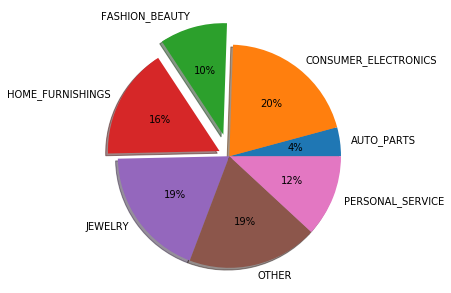

In [491]:
### Number of Merchants
plt.figure(figsize=(6,5))
pie=pd.DataFrame(data.groupby(['category_m']).merchant_id.nunique())
labels= pie.index
sizes = pie.merchant_id

explode=[0,0,0.2,0.1,0,0,0]

plt.pie(sizes, explode=explode,labels=labels, autopct='%1.0f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.show()

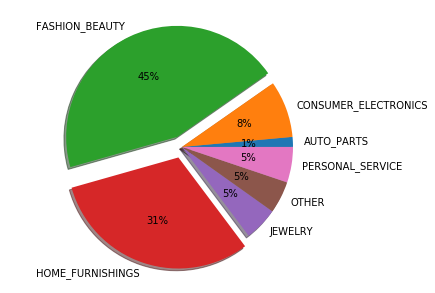

In [698]:
### Total Loan Amount
plt.figure(figsize=(6,5))
pie=pd.DataFrame(data.groupby(['category_m']).total_loan_amt.sum())
labels= pie.index
sizes = pie.total_loan_amt

explode=[0,0,0.1,0.1,0,0,0]
plt.pie(sizes, explode=explode,labels=labels, autopct='%1.0f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.show()

### Plot the distribution/Histogram of some key attributes 

In [341]:
def plot_hist(df,var):
    plt.figure(figsize=(20,30))
    j=0
    for i in var:
        plt.subplot(len(var)*100+40+j+1)
        q1=df[i].quantile(0.05)
        q2=df[i].quantile(0.95)
        plt.hist(df[i],range=(q1,q2),bins=50)
        plt.xlabel(i)
        j=j+1

def plot_kde(df,var):
    plt.figure(figsize=(20,30))
    j=0
    for i in var:
        plt.subplot(len(var)*100+40+j+1)
        q1=df[i].quantile(0.01)
        q2=df[i].quantile(0.99)
        sns.kdeplot(df[i])
#         plt.xlim(q1,q2)
        plt.xlabel(i)
        j=j+1
        
def plot_scatter(df,x,y):
    plt.scatter(x, y,data=df)
    plt.xlabel(x)
    plt.ylabel(y)

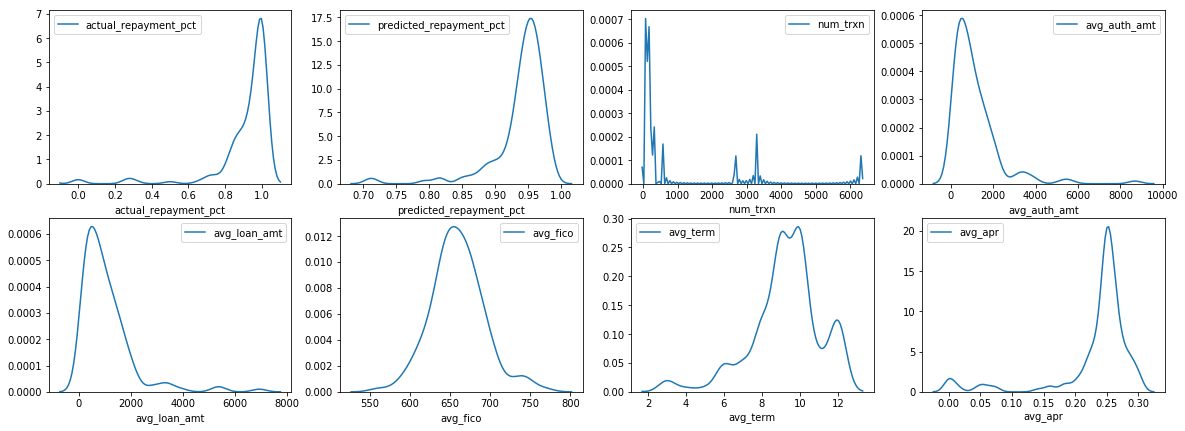

In [268]:
plot_var=['actual_repayment_pct', 'predicted_repayment_pct','num_trxn', 'avg_auth_amt','avg_loan_amt', 'avg_fico', 'avg_term','avg_apr']
plot_kde(data,plot_var)

#### Create bins based on the distribution

In [548]:
data['num_txn_bin']=pd.cut(data['num_trxn'],bins=(-1,10,100,data['num_trxn'].max())).astype(str)
data['avg_loan_amt_bin']=pd.cut(data['avg_loan_amt'],bins=(-1,200,500,1000,data['avg_loan_amt'].max())).astype(str)
data['avg_fico_bin']=pd.cut(data['avg_fico'],bins=(-1,620,660,700,data['avg_fico'].max())).astype(str)

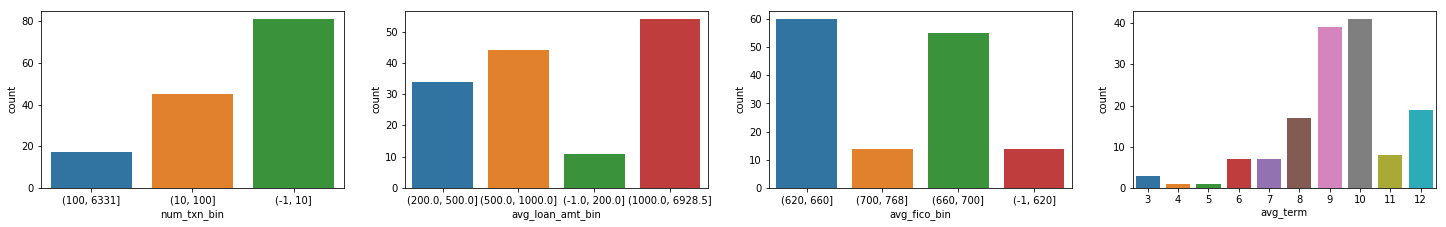

In [554]:
plt.figure(figsize=(25,15))
plt.subplot(441)
sns.countplot('num_txn_bin',data=data)
plt.subplot(442)
sns.countplot('avg_loan_amt_bin',data=data)
plt.subplot(443)
sns.countplot('avg_fico_bin',data=data)
plt.subplot(444)
sns.countplot('avg_term',data=data)

#### Calculated fields:
1. Gap between predicted_repayment_pct and actual_repayment_pct
2. Gap between avg_auth_amt and avg_loan_amt
3. Credit Loss: avg_loan_amt * (1-actual_repayment_pct)
4. Expected Interest Income: (avg_apr/12) ** term * loan_amt (simplified calculation)
5. Estimated Profit = Expected Interest Income - Credit Loss

In [644]:
data['diff_repayment_pct']=data['predicted_repayment_pct']-data['actual_repayment_pct']
data['diff_loan_amt']=data['avg_loan_amt']-data['avg_auth_amt']
data['diff_loan_amt_prc']=data['diff_loan_amt']/data['avg_auth_amt']
data['avg_loss']=data['avg_loan_amt']*(1-data['actual_repayment_pct'])
data['avg_interest']=data['avg_loan_amt']*(data['avg_apr']/12)*data['avg_term']
data['avg_raw_profit']=data['avg_interest']-data['avg_loss']
data['avg_profit_rate']=data['avg_raw_profit']/data['avg_loan_amt']
data['total_raw_profit']=data['avg_raw_profit']*data['num_trxn']

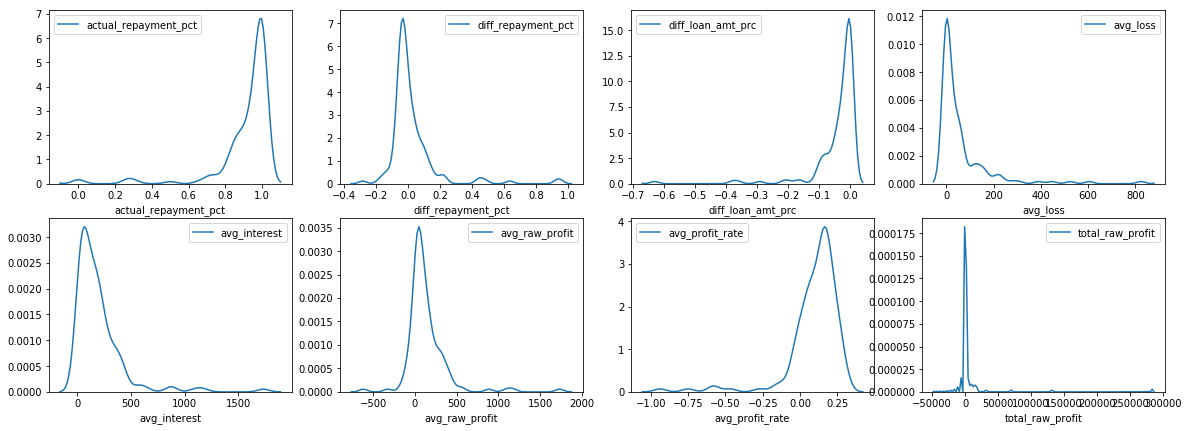

In [645]:
plot_var=['actual_repayment_pct','diff_repayment_pct','diff_loan_amt_prc','avg_loss','avg_interest','avg_raw_profit','avg_profit_rate','total_raw_profit']
plot_kde(data,plot_var)

In [643]:
data[plot_var+['avg_apr','avg_term','avg_fico']].head()

,actual_repayment_pct,diff_repayment_pct,avg_loan_amt,diff_loan_amt_prc,avg_loss,avg_interest,avg_raw_profit,avg_profit_rate,avg_apr,avg_term,avg_fico
0,0.927466,0.020959,473.727737,-0.036454,34.361345,79.332973,44.971628,0.094931,0.251198,8,643
1,0.983798,-0.005157,862.555109,-0.000512,13.974946,0.000000,-13.974946,-0.016202,0.000000,6,715
2,0.936782,0.028261,620.229734,-0.025853,39.209943,88.757769,49.547826,0.079886,0.214657,8,664
3,0.961743,-0.016109,692.877934,-0.037287,26.507597,148.724516,122.216919,0.176390,0.257577,10,655
4,0.867273,0.035135,374.832065,-0.016133,49.750462,45.180570,-4.569891,-0.012192,0.160714,9,626


# Part 2: Analysis

### 1. What drives the variance between actual and predicted repayment?

In [476]:
data.diff_repayment_pct.describe()

count    143.000000
mean       0.023351
std        0.157319
min       -0.284113
25%       -0.045782
50%       -0.016109
75%        0.037041
max        0.950731
Name: diff_repayment_pct, dtype: float64

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


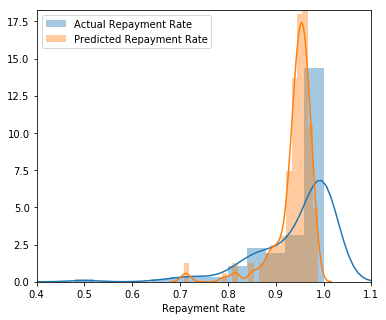

In [362]:
## Overall Distribution of Actual and Predicated

plt.figure(figsize=(6, 5))
sns.distplot(data.actual_repayment_pct, bins=25, label='Actual Repayment Rate')
sns.distplot(data.predicted_repayment_pct,bins=25, label='Predicted Repayment Rate')
plt.xlim(0.4,1.1)
plt.xlabel('Repayment Rate')
plt.legend()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


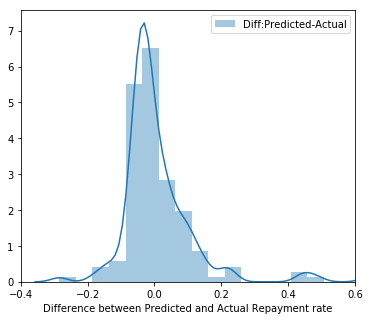

In [424]:
## Overall Distribution of difference 
plt.figure(figsize=(6, 5))
sns.distplot(data.diff_repayment_pct, bins=25,label='Diff:Predicted-Actual')
plt.xlim(-0.4,0.6)
plt.xlabel('Difference between Predicted and Actual Repayment rate')
plt.legend()

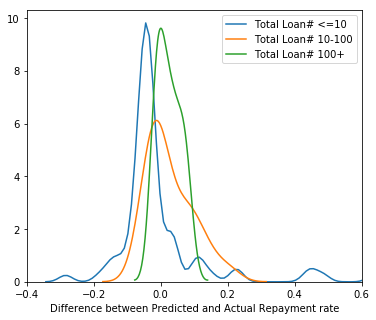

In [503]:
##  Distribution by different merchant size

a=data.eval("""num_trxn<=10""")
b=data.eval("""num_trxn>10 and num_trxn<=100""")
# c=data.eval("""num_trxn>100 and num_trxn<=500""")
d=data.eval("""num_trxn>100 """)

plt.figure(figsize=(6, 5))
sns.kdeplot(data.loc[a].diff_repayment_pct, label='Total Loan# <=10')
sns.kdeplot(data.loc[b].diff_repayment_pct, label='Total Loan# 10-100')
# sns.kdeplot(data.loc[c].diff_repayment_pct, label='Total Loan# 100-500')
sns.kdeplot(data.loc[d].diff_repayment_pct, label='Total Loan# 100+')
# sns.kdeplot(data.diff_repayment_pct, label='Total Population')

plt.xlim(-0.4,0.6)
plt.xlabel('Difference between Predicted and Actual Repayment rate')
plt.legend()

### Correlation matrix does not show significant correlation

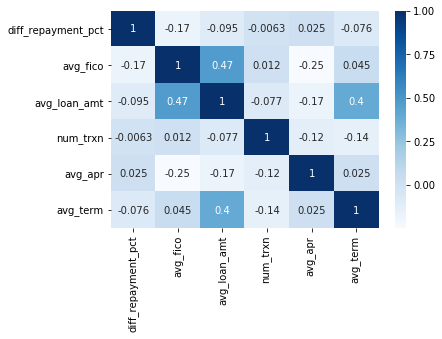

In [418]:
x_var=data[['diff_repayment_pct','category_m','avg_fico','avg_loan_amt','num_trxn','avg_apr','avg_term']]
corr=x_var.corr()
sns.heatmap(corr,cmap="Blues",annot=True)

### 2. What could drive the difference between auth_amount and loan_amount?

In [619]:
data.diff_loan_amt_prc.quantile(0.2)

-0.056949381670232405

In [609]:
data[['avg_auth_amt','avg_loan_amt','diff_loan_amt','diff_loan_amt_prc']].describe()

,avg_auth_amt,avg_loan_amt,diff_loan_amt,diff_loan_amt_prc
count,143.000000,143.000000,143.000000,143.000000
mean,1127.141393,1054.581982,-72.559411,-0.039979
std,1138.127493,1017.087293,244.858507,0.078531
min,79.840000,79.840000,-2132.500000,-0.630451
25%,407.905850,400.360792,-41.156920,-0.045361
50%,843.750000,823.333333,-7.873000,-0.015124
75%,1432.083563,1325.176389,0.000000,0.000000
max,8673.500000,6928.500000,0.000000,0.000000


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


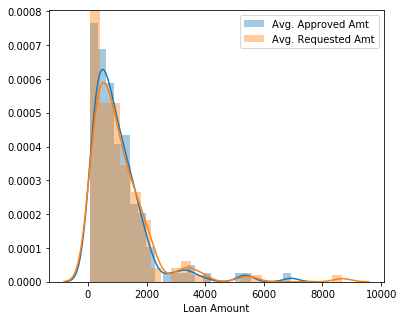

In [452]:
## Overall Distribution of Actual and Predicated
plt.figure(figsize=(6, 5))
sns.distplot(data.avg_loan_amt, bins=25, label='Avg. Approved Amt')
sns.distplot(data.avg_auth_amt,bins=25, label='Avg. Requested Amt')
# plt.xlim(0.4,1.1)
plt.xlabel('Loan Amount')
plt.legend()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


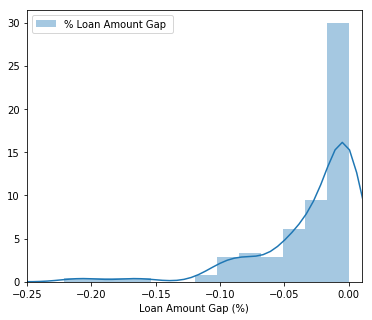

In [620]:
## Overall Distribution of Actual and Predicated
plt.figure(figsize=(6, 5))
sns.distplot(data.diff_loan_amt_prc, label='% Loan Amount Gap ')
# sns.distplot(data.avg_auth_amt,bins=25, label='Avg. Requested Amt')
plt.xlim(-0.25,0.01)
plt.xlabel('Loan Amount Gap (%)')
plt.legend()

Text(0,0.5,'Average Loan Amount Gap')

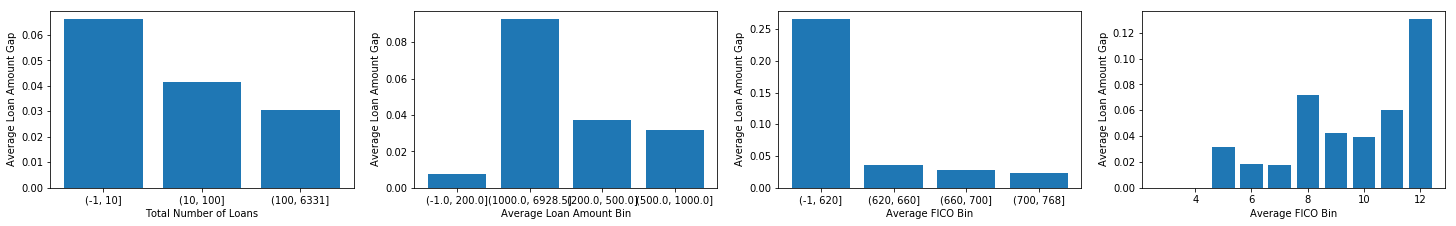

In [558]:
### By bin 
plt.figure(figsize=(25,15))

plt.subplot(441)
a=pd.DataFrame(data.groupby(['num_txn_bin'])['diff_loan_amt_prc'].mean())
a.reset_index(inplace=True)
plt.bar('num_txn_bin','diff_loan_amt_prc',data=a)
plt.xlabel('Total Number of Loans')
plt.ylabel('Average Loan Amount Gap')

plt.subplot(442)
a=pd.DataFrame(data.groupby(['avg_loan_amt_bin'])['diff_loan_amt_prc'].mean())
a.sort_index(inplace=True)
a.reset_index(inplace=True)
plt.bar('avg_loan_amt_bin','diff_loan_amt_prc',data=a)
plt.xlabel('Average Loan Amount Bin')
plt.ylabel('Average Loan Amount Gap')


plt.subplot(443)
a=pd.DataFrame(data.groupby(['avg_fico_bin'])['diff_loan_amt_prc'].mean())
a.reset_index(inplace=True)
plt.bar('avg_fico_bin','diff_loan_amt_prc',data=a)
plt.xlabel('Average FICO Bin')
plt.ylabel('Average Loan Amount Gap')

plt.subplot(444)
a=pd.DataFrame(data.groupby(['avg_term'])['diff_loan_amt_prc'].mean())
a.reset_index(inplace=True)
plt.bar('avg_term','diff_loan_amt_prc',data=a)
plt.xlabel('Average FICO Bin')
plt.ylabel('Average Loan Amount Gap')


Text(0.5,1,'Average Loan Amt Gap (%)')

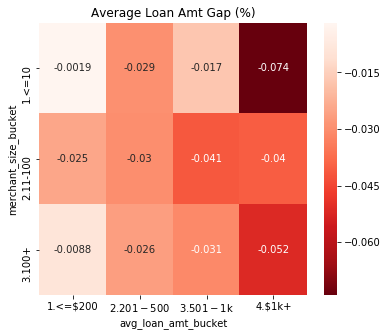

In [614]:
def loan_amt_bucket(x):
    if x<=200:
        y='1.<=$200'
    elif x>200 and x<=500:
        y='2.$201-$500'
    elif x>500 and x<=1000:
        y='3.$501-$1k'
    else:
        y='4.$1k+'
    return y

def size_bucket(x):
    if x<=10:
        y='1.<=10'
    elif x>10 and x<=100:
        y='2.11-100'
    else:
        y='3.100+'
    return y

data['avg_loan_amt_bucket']=data['avg_loan_amt'].apply(loan_amt_bucket)
data['merchant_size_bucket']=data['num_trxn'].apply(size_bucket)
cross=pd.DataFrame(data.loc[data['diff_loan_amt_prc']>=-1].groupby(['merchant_size_bucket','avg_loan_amt_bucket'])['diff_loan_amt_prc'].mean())
new= pd.pivot_table(cross, values=['diff_loan_amt_prc'], index=['merchant_size_bucket'],columns=['avg_loan_amt_bucket'])
new.columns=new.columns.droplevel(level=0)

plt.figure(figsize=(6,5))
sns.heatmap(new,cmap="Reds_r", annot=True, )
plt.title('Average Loan Amt Gap (%)')

Text(0.5,1,'Average Loan Amt Gap (%)')

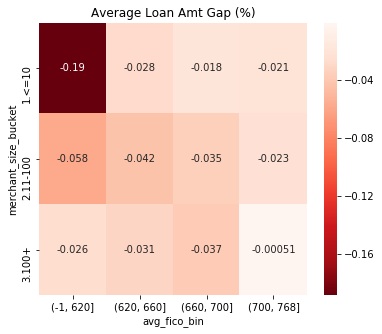

In [615]:
cross=pd.DataFrame(data.loc[data['diff_loan_amt_prc']>=-1].groupby(['merchant_size_bucket','avg_fico_bin'])['diff_loan_amt_prc'].mean())
new= pd.pivot_table(cross, values=['diff_loan_amt_prc'], index=['merchant_size_bucket'],columns=['avg_fico_bin'])
new.columns=new.columns.droplevel(level=0)

plt.figure(figsize=(6,5))
sns.heatmap(new,cmap="Reds_r", annot=True)
plt.title('Average Loan Amt Gap (%)')

In [566]:
data.groupby(['merchant_size_bucket','avg_loan_amt_bucket'])['merchant_id'].count()

merchant_size_bucket  avg_loan_amt_bucket
1.<=10                1.<=$200                7
                      2.$201-$500            22
                      3.$501-$1k             18
                      4.$1k+                 34
2.11-100              1.<=$200                2
                      2.$201-$500             7
                      3.$501-$1k             18
                      4.$1k+                 18
3.100+                1.<=$200                2
                      2.$201-$500             5
                      3.$501-$1k              8
                      4.$1k+                  2
Name: merchant_id, dtype: int64

## 3. Most profitable Catergory

### How to define the profitability for company XYZ? 
##### Profit= Interest Charge - Credit Loss = (apr/12 ** term (month) * Loan Amount )-(Loan Amount * (1-repayment rate))
##### Profit rate = raw profit / avg_loan_amount

In [646]:
data['toal_profit_rate']=data['total_raw_profit']/data['total_loan_amt']

In [651]:
## profitability
profit_sum=pd.DataFrame(data.groupby(['category_m']).agg({'avg_raw_profit':['count','mean'],'avg_interest':['mean'],'avg_loss':['mean']}))
profit_sum

avg_raw_profit             avg_interest    avg_loss
                              count        mean         mean        mean
category_m                                                              
AUTO_PARTS                        6   70.815670   223.909118  153.093448
CONSUMER_ELECTRONICS             29   90.331165   142.235959   51.904794
FASHION_BEAUTY                   14   92.478012   112.295998   19.817986
HOME_FURNISHINGS                 23  209.311717   226.596994   17.285277
JEWELRY                          27  223.853732   262.227889   38.374157
OTHER                            27   73.679272   191.906754  118.227483
PERSONAL_SERVICE                 17  124.139626   202.349603   78.209977

### Calculate Total Loan Amount Rate by Industry

In [690]:
profit_sum=pd.DataFrame(data.groupby(['category_m'])['total_raw_profit','total_loan_amt'].sum())
profit_sum['total_raw_profit_rate']=profit_sum['total_raw_profit']/profit_sum['total_loan_amt']
profit_sum.sort_values(by='total_raw_profit_rate', inplace=True)
profit_sum

,total_raw_profit,total_loan_amt,total_raw_profit_rate
category_m,,,
HOME_FURNISHINGS,16249.354275,3.425486e+06,0.004744
OTHER,23573.782727,5.186673e+05,0.045451
AUTO_PARTS,11739.505418,1.604847e+05,0.073150
FASHION_BEAUTY,439674.296793,4.960410e+06,0.088637
JEWELRY,49573.840920,5.441283e+05,0.091107
PERSONAL_SERVICE,59238.900653,5.744630e+05,0.103120
CONSUMER_ELECTRONICS,130670.450480,9.175075e+05,0.142419


Text(0,0.5,'Industry')

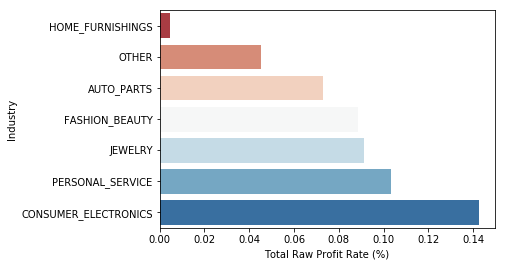

In [688]:
sns.barplot(y=profit_sum.index, x='total_raw_profit_rate', data=profit_sum, orient='h',palette="RdBu")
plt.xlabel('Total Raw Profit Rate (%)')
plt.ylabel('Industry')

### By Industry and Merchant Size 

Text(0.5,1,'Total Gross Profit Rate (%)')

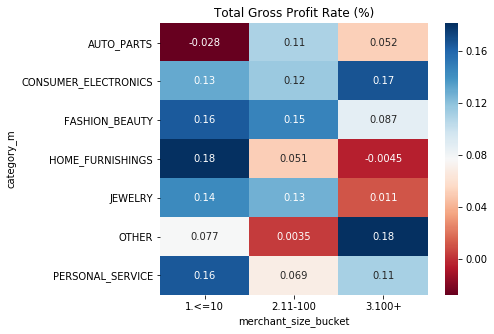

In [704]:
cross=pd.DataFrame(data.groupby(['category_m','merchant_size_bucket'])['total_raw_profit','total_loan_amt'].sum())
cross['total_raw_profit_rate']=cross['total_raw_profit']/cross['total_loan_amt']
cross.sort_values(by='total_raw_profit_rate', inplace=True)
new= pd.pivot_table(cross, values=['total_raw_profit_rate'], index=['category_m'],columns=['merchant_size_bucket'])
new.columns=new.columns.droplevel(level=0)

plt.figure(figsize=(6,5))
sns.heatmap(new,cmap="RdBu", annot=True)
plt.title('Total Gross Profit Rate (%)')

In [702]:
new= pd.pivot_table(cross, values=['total_raw_profit'], index=['category_m'],columns=['merchant_size_bucket'])
new

total_raw_profit                             
merchant_size_bucket           1.<=10      2.11-100         3.100+
category_m                                                        
AUTO_PARTS                -245.205632   7855.064684    4129.646366
CONSUMER_ELECTRONICS      8270.408327  45333.450564   77066.591590
FASHION_BEAUTY            2251.212310  12850.334641  424572.749841
HOME_FURNISHINGS         14240.002939  15573.433796  -13564.082460
JEWELRY                  12485.510108  35135.186739    1953.144073
OTHER                     4943.808017   1242.294310   17387.680400
PERSONAL_SERVICE          4243.381696   9920.135807   45075.383150

In [695]:
cross=pd.DataFrame(data.groupby(['category_m','merchant_size_bucket'])['merchant_id'].count())
new= pd.pivot_table(cross, values=['merchant_id'], index=['category_m'],columns=['merchant_size_bucket'])
new

merchant_id                
merchant_size_bucket      1.<=10 2.11-100 3.100+
category_m                                      
AUTO_PARTS                     2        3      1
CONSUMER_ELECTRONICS          14       13      2
FASHION_BEAUTY                 6        3      5
HOME_FURNISHINGS              15        6      2
JEWELRY                       17        8      2
OTHER                         19        7      1
PERSONAL_SERVICE               8        5      4

Text(0.5,1,'Average Profit Rate (%)')

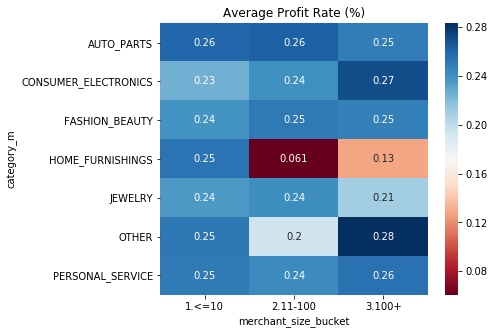

In [662]:
cross=pd.DataFrame(data.groupby(['category_m','merchant_size_bucket'])['avg_apr'].mean())
new= pd.pivot_table(cross, values=['avg_apr'], index=['category_m'],columns=['merchant_size_bucket'])
new.columns=new.columns.droplevel(level=0)

plt.figure(figsize=(6,5))
sns.heatmap(new,cmap="RdBu", annot=True)
plt.title('Average Profit Rate (%)')

Text(0.5,1,'Average Profit Rate (%)')

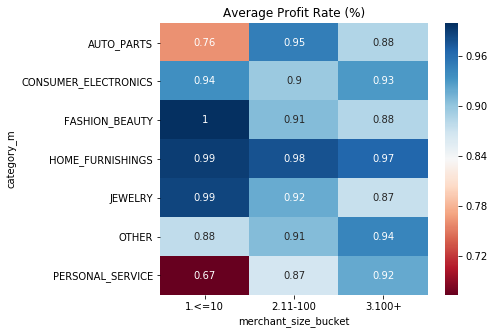

In [668]:
cross=pd.DataFrame(data.groupby(['category_m','merchant_size_bucket'])['actual_repayment_pct'].mean())
new= pd.pivot_table(cross, values=['actual_repayment_pct'], index=['category_m'],columns=['merchant_size_bucket'])
new.columns=new.columns.droplevel(level=0)

plt.figure(figsize=(6,5))
sns.heatmap(new,cmap="RdBu", annot=True)
plt.title('Average Profit Rate (%)')